#CafChem tools for Hit expansion

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/Research_Notebooks/blob/main/Hit_Expansion_CafChem.ipynb)

## This notebook allows you to:
- use generative mask-filling to create analogues of a given molecular SMILES string
- perform substitutions on substituted and unsubstituted carbons on a ring on a molecular SMILES string.

## Requirements:
- This notebook will install deepchem, datasets, and py3Dmol
- It will pull the CafChem tools from Github.
- It will install all needed libraries.
- You need to have a HF_Token set as a secret to access the mask-filling model.

## Set-up libraries

In [1]:
! pip install -U datasets
! pip install deepchem
! pip install py3Dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; plat

In [2]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 8.71 KiB | 8.71 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
import torch
import pandas as pd
import huggingface_hub
import transformers
import datasets
import numpy as np
from pathlib import Path
from datasets import load_dataset,Dataset
from transformers import AutoTokenizer
from transformers import pipeline
import random
import os
import re
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol
from rdkit.Chem import Draw
from google.colab import files
import CafChem.CafChemSubs as ccs

cpuCount = os.cpu_count()
print("Number of CPUs in the system:", cpuCount)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Number of CPUs in the system: 2


## Set up HF models for mask-filling
- must have a HF token enabled!

In [4]:
model_size = 250
model_name = f"cafierom/bert-base-cased-ChemTok-ZN{model_size}K-V1"
ccs.genmask_model_setup(model_size, model_name)

tokenizer_config.json:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/672k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Device set to use cpu


## Substitutions
- Create substitutions on phenyl rings.
- use ccs.which_fragments() to see what fragments are defined for substitution.
- use ccs.add_fragment() to add your own fragments.

In [5]:
number_subs = 1         # how many substitutions to make per molecule
smile = 'c1c(O)cccc1'
ccs.which_fragments()
ccs.add_fragment("c(C)c", "methyl")
smiles_list, qed_list, mol_list, legends_list, pic = ccs.sub_rings(smile,number_subs)

substitution_dict = {"Substituted Molecules": smiles_list}
df = pd.DataFrame.from_dict(substitution_dict)
csv_string = f"Ring_sub_{int(len(smiles_list))}_on_{smile}"
csv_string = csv_string.strip(" ")
print(f"Saving: {csv_string}")
df.to_csv(csv_string+".csv",index=False)

Name: Fluoro     Fragment: c(F)c
Name: Cyano     Fragment: c(C#N)c
Name: Iodo     Fragment: c(I)c
Name: Nitro     Fragment: c([N+]([O-])=O)c
Name: Methoxy     Fragment: c(OC)c
Name: Chloro     Fragment: c(Cl)c
Fragment added:
Name: methyl     Fragment: c(C)c
Substituted 21 molecules
Could not match 0 requests.
Saving: Ring_sub_21_on_c1c(O)cccc1


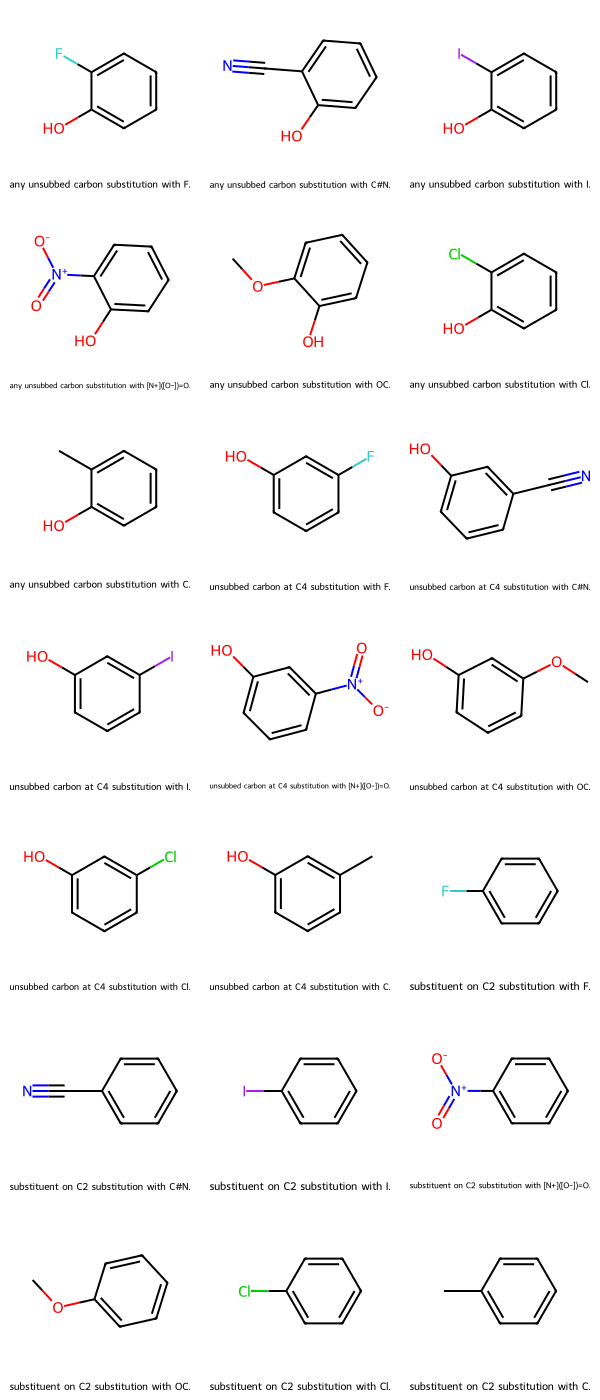

In [6]:
pic

## Mask-filling

First masking generated 6 SMILES
Last masking generated 3 SMILES
Random masking generated 1 SMILES
Random masking generated 1 SMILES
Random masking generated 2 SMILES
Random masking generated 0 SMILES
Total SMILES generated: 13
Total unique SMILES generated: 8
Average entropy: 0.38727373441180885
Total SMILES generated for hit: 8
analogue 1: OOc1ccc(/C=C/c2cc(O)cc(O)c2)cc1 with QED: 0.440
analogue 2: CCOc1ccc(/C=C/c2cc(O)cc(O)c2)cc1 with QED: 0.821
analogue 3: CC(=O)c1ccc(/C=C/c2cc(O)cc(O)c2)cc1 with QED: 0.651
analogue 4: Oc1ccc(/C=C/c2cc(O)ccc2O)cc1 with QED: 0.547
analogue 5: Oc1ccc(/C=C\c2cc(O)cc(O)c2)cc1 with QED: 0.692
analogue 6: Oc1ccc(/C=C/c2cc(O)cc(O)c2)cc1 with QED: 0.692
analogue 7: COc1ccc(/C=C/c2cc(O)cc(O)c2)cc1 with QED: 0.812
analogue 8: Cc1ccc(/C=C/c2cc(O)cc(O)c2)cc1 with QED: 0.768

Average entropy: 0.38727373441180885


[11:56:54] Explicit valence for atom # 0 O, 3, is greater than permitted
[11:56:54] SMILES Parse Error: syntax error while parsing: Olc1ccc(cc1)\C=C\c2cc(O)cc(O)c2
[11:56:54] SMILES Parse Error: check for mistakes around position 2:
[11:56:54] Olc1ccc(cc1)\C=C\c2cc(O)cc(O)c2
[11:56:54] ~^
[11:56:54] SMILES Parse Error: Failed parsing SMILES 'Olc1ccc(cc1)\C=C\c2cc(O)cc(O)c2' for input: 'Olc1ccc(cc1)\C=C\c2cc(O)cc(O)c2'
[11:56:54] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[11:56:54] SMILES Parse Error: unclosed ring for input: 'Oc1ccc(cc1)\C=C\c2cc(O)ccc1O'
[11:56:54] SMILES Parse Error: unclosed ring for input: 'Oc1ccc(cc1)\C=C\c2cc(O)cc(O)O'


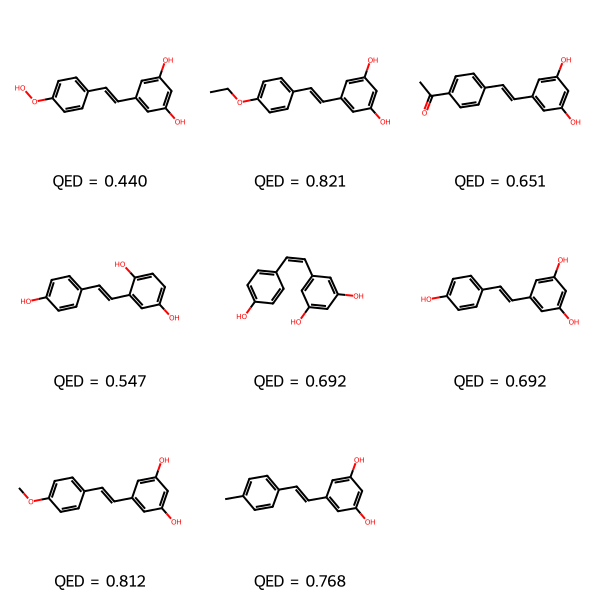

In [20]:
resveratrol = "Oc1ccc(cc1)\C=C\c2cc(O)cc(O)c2"
percent_to_use = 0.15

unique_smiles, unique_entropies, qeds, mols, out_text, pic = ccs.gen_mask(resveratrol,percent_to_use)

print(out_text)
print(f"Average entropy: {sum(unique_entropies)/len(unique_entropies)}")

pic

## Using both techniques

In [25]:
resveratrol = "Oc1ccc(cc1)\C=C\c2cc(O)cc(O)c2"
percent_to_use = 0.15

unique_smiles, unique_entropies, qeds, mols, out_text, pic = ccs.gen_mask(resveratrol,percent_to_use)
print(out_text)

total_smiles = []
total_qed = []
total_mols = []
for smile in unique_smiles:
  smiles_list, qed_list, mol_list, legends_list, pic = ccs.sub_rings(smile,number_subs)
  total_smiles.extend(smiles_list)
  total_qed.extend(qed_list)
  total_mols.extend(mol_list)

qed_leg = [f"QED: {qed:.3f}" for qed in total_qed]
print("=============================================================")
print(f"Total molecules made: {len(total_smiles)}")
print(f"Total QED: {sum(total_qed)/len(total_qed)}")

First masking generated 6 SMILES
Last masking generated 3 SMILES
Random masking generated 2 SMILES
Random masking generated 1 SMILES
Random masking generated 0 SMILES
Random masking generated 0 SMILES
Total SMILES generated: 12
Total unique SMILES generated: 6
Average entropy: 0.527879384255684
Total SMILES generated for hit: 6
analogue 1: OOc1ccc(/C=C/c2cc(O)cc(O)c2)cc1 with QED: 0.440
analogue 2: CCOc1ccc(/C=C/c2cc(O)cc(O)c2)cc1 with QED: 0.821
analogue 3: CC(=O)c1ccc(/C=C/c2cc(O)cc(O)c2)cc1 with QED: 0.651
analogue 4: Oc1ccc(/C=C/c2cc(O)ccc2O)cc1 with QED: 0.547
analogue 5: Oc1ccc(/C=C\c2cc(O)cc(O)c2)cc1 with QED: 0.692
analogue 6: Oc1ccc(/C=C/c2cc(O)cc(O)c2)cc1 with QED: 0.692

Substituted 7 molecules
Could not match 18 requests.
Substituted 7 molecules
Could not match 18 requests.
Substituted 7 molecules
Could not match 18 requests.
Substituted 14 molecules


[12:01:39] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:01:39] SMILES Parse Error: syntax error while parsing: Olc1ccc(cc1)\C=C\c2cc(O)cc(O)c2
[12:01:39] SMILES Parse Error: check for mistakes around position 2:
[12:01:39] Olc1ccc(cc1)\C=C\c2cc(O)cc(O)c2
[12:01:39] ~^
[12:01:39] SMILES Parse Error: Failed parsing SMILES 'Olc1ccc(cc1)\C=C\c2cc(O)cc(O)c2' for input: 'Olc1ccc(cc1)\C=C\c2cc(O)cc(O)c2'
[12:01:39] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[12:01:39] SMILES Parse Error: unclosed ring for input: 'Oc1ccc(cc1)\C=C\c2cc(O)ccc1O'
[12:01:39] SMILES Parse Error: unclosed ring for input: 'Oc1ccc(cc1)\C=C\c2cc(O)cc(O)O'
[12:01:39] SMILES Parse Error: unclosed ring for input: 'Oc1ccc(Br)\C=C\c2cc(O)cc(O)c2'


Could not match 18 requests.
Substituted 7 molecules
Could not match 18 requests.
Substituted 7 molecules
Could not match 18 requests.
Total molecules made: 49
Total QED: 0.5897155846584152


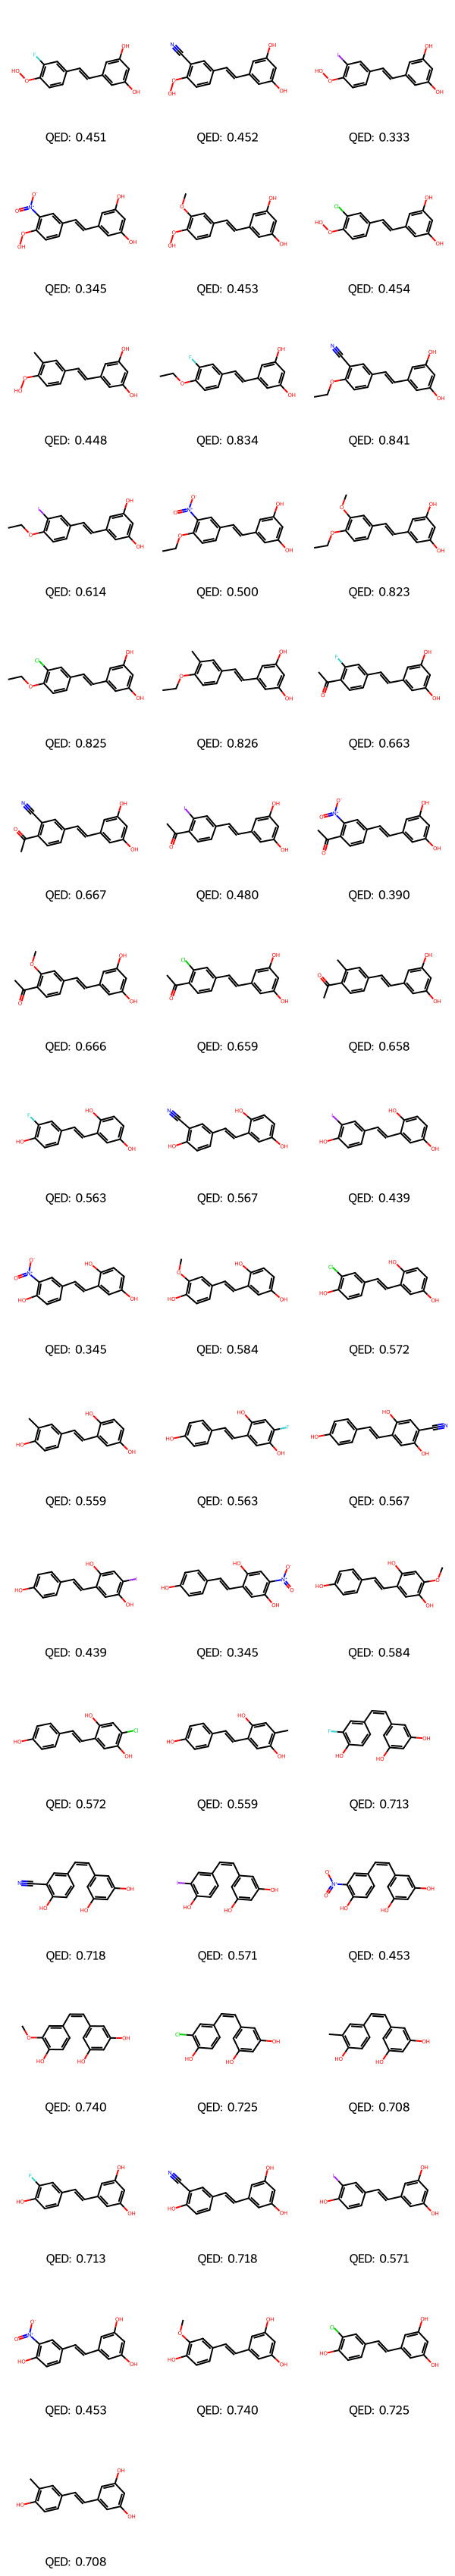

In [26]:
Chem.Draw.MolsToGridImage(total_mols, legends = qed_leg)

## Save XYZ files and visualize

In [7]:
for i,smile in enumerate(smiles_list):
  filename = f"mol{i}.xyz"
  _ = ccs.smileToXYZ(smile,filename)

XYZ file saved as mol0.xyz
XYZ file saved as mol1.xyz
XYZ file saved as mol2.xyz
XYZ file saved as mol3.xyz
XYZ file saved as mol4.xyz
XYZ file saved as mol5.xyz
XYZ file saved as mol6.xyz
XYZ file saved as mol7.xyz
XYZ file saved as mol8.xyz
XYZ file saved as mol9.xyz
XYZ file saved as mol10.xyz
XYZ file saved as mol11.xyz
XYZ file saved as mol12.xyz
XYZ file saved as mol13.xyz
XYZ file saved as mol14.xyz
XYZ file saved as mol15.xyz
XYZ file saved as mol16.xyz
XYZ file saved as mol17.xyz
XYZ file saved as mol18.xyz
XYZ file saved as mol19.xyz
XYZ file saved as mol20.xyz


In [ ]:
f = open("mol0.xyz","r")
structure = f.read()
f.close()

ccs.visualize_molecule(structure)